In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.optimize import curve_fit
import scipy
import matplotlib.cm as cm

In [2]:
import seaborn as sns
sns.set()
# sns.set_style("white")
sns.set_style("whitegrid")
plt.rc('font', family='serif')

## Define Functions

In [3]:
## calculate cost of perturbation due to carbon
## input: temperature profile, perturbed temperature profile, total consumption, and discount function

def cost_of_perturbation(T, T_perturb, W, discount_function, gamma=2, D0=0.00267):
    S_Wt = D0*T**gamma
    S_Wt_perturb = D0*T_perturb**gamma
    consumption_loss_fraction = S_Wt_perturb-S_Wt
    absolute_consumption_loss = consumption_loss_fraction*W
    discounted_consumption_loss = absolute_consumption_loss*discount_function
    area = simps(discounted_consumption_loss, dx=1)
    cost = area*10**12  # convert to dollar amount
    
    return cost

In [4]:
## calculate abatement given a carbon price

# default settings
P_50 = 100  # 187.5 * 0.7625000000000001
P_100 = 300  # 187.5
consumption_growth = 0.02
W_2019 = 80
consumption_discount=0.035
s = 0.05
r = 0.03

def abatement(P, P0, P_50=P_50, r=r, s=s, P_100=P_100):  # 0.05
    if P0 >= P_50:
        print("P0 is greater than P_50")
    elif ((P_100-P0)/(P_50-P0))**(s/r) <= 2:
        print("MAC curve condition not satisfied")
    
    P_h = P0 + ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)
    Am = 1 + ((P_100 - P0) / (P_h - P0)) ** (-s / r)
    
    A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
    
    return A

In [5]:
## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

# Steps outlined in Email

## 1. Create Unperturbed Temperature Profile

In [6]:
# get historical data (taken from chrisroadmap)

T_gas_df = pd.read_csv("T_gas.csv", index_col=0)

# T_2019 = T_gas_df['CO2_best'][2019]

T_2019 = 1.2

In [7]:
start_year = 1750
last_historical_year = 2019
end_year = 3000

years = np.arange(start_year, end_year+1)
T_forecast_years = np.arange(last_historical_year, end_year+1)
T_forecast_length = end_year - last_historical_year + 1

In [8]:
delta_T = 3
alpha = 0.02
T_forecast = T_2019 + (delta_T - T_2019) * (1 - np.exp(-alpha*np.arange(T_forecast_length)))

In [9]:
T = np.concatenate([T_gas_df['CO2_best'],T_forecast[1:]])

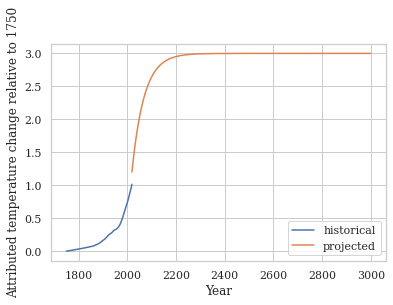

In [10]:
plt.plot(T_gas_df['CO2_best'], label="historical")
plt.plot(T_forecast_years, T_forecast, label="projected")
plt.xlabel("Year")
plt.ylabel("Attributed temperature change relative to 1750")
plt.legend()

## Total Consumption

In [11]:
W = []

# for i in range(len(years)):
#     W.append(W0*consumption_growth**(i-(last_historical_year - start_year)))
    
for i in range(len(years)):
    W.append(W_2019*np.exp(consumption_growth*(i-(last_historical_year - start_year))))

W = np.asarray(W)

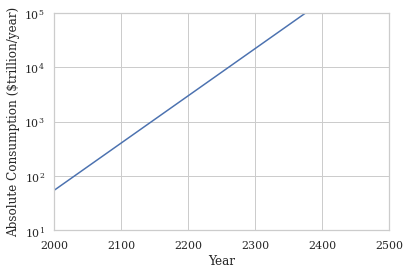

In [12]:
plt.plot(years, W)
plt.xlabel("Year")
plt.ylabel("Absolute Consumption ($trillion/year)")
# plt.xlim(2000, 2100)
# plt.ylim(0, 400)
plt.xlim(2000, 2500)
plt.ylim(10, 100000)
plt.yscale("log")

alternative functional form for above for the fast transition

## 2. Calculate SCC as a function of time for a range of years

In [13]:
shift = 1

In [14]:
color_list = ["r", "g", "c", "m", "b"] # r y pink g

Text(0, 0.5, 'Temperature Anomaly (K)')

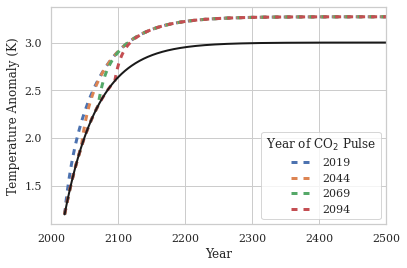

In [15]:
## years to calculate SCC
first_perturbed_year = last_historical_year
last_perturbed_year = 2500
year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

# consumption_discount = 0.035
# consumption_discount = consumption_growth + 0.015

SCC_list = []

perturbed_temperature_list = []
perturbed_year_temperature_list = []

for j in range(len(year_of_perturbation)):  # len(year_of_perturbation)
    ## define perturbed temperature profile for a given year
    T_TCRE = 0.00054  # need to check this for FAIR!
    k_s = 0.12
    
    num_of_GtCO2 = 500

    T_p = np.zeros(T_forecast_length)
    for i in range(len(T_forecast_years)):
        if year_of_perturbation[j] <= T_forecast_years[i]:
            T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))*num_of_GtCO2  # # perturbed by 1GtCO2
    T_forecast_perturbed = T_forecast+T_p
    T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])
    
    if j % 25 == 0:
        plt.plot(T_forecast_years+shift, T_forecast_perturbed, label=j+last_historical_year, linestyle='dashed', linewidth=3, dashes=(2, 2))
        perturbed_temperature_list.append(T_forecast_perturbed)
        perturbed_year_temperature_list.append(j+last_historical_year+shift)
    
    ## define discount function
    num_of_years = len(years)
    discount_function = np.zeros(num_of_years)

    for i in range(num_of_years):
        if years[i] >= year_of_perturbation[j]:
            discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
    
    ## calculate SCC
    cost = cost_of_perturbation(T=T, T_perturb=T_perturbed, W=W, discount_function=discount_function)
    SCC = cost/(10**9*num_of_GtCO2)
    if SCC < P_100:
        SCC_list.append(SCC)
    else:
        SCC_list.append(P_100)
        break

plt.legend(title="Year of CO$_2$ Pulse")
plt.plot(T_forecast_years+shift, T_forecast, color="k", linewidth=2)  #  label="unperturbed",
plt.xlim(2000, 2500)
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (K)")

In [16]:
import matplotlib.ticker as ticker

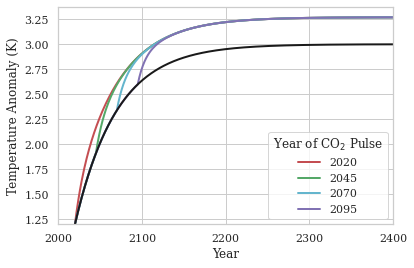

In [17]:
# fig = plt.figure()
fig, ax = plt.subplots()  

for i in range(len(perturbed_temperature_list)):
    plt.plot(T_forecast_years+shift, perturbed_temperature_list[i], label=perturbed_year_temperature_list[i], linewidth=2, color=color_list[i])

plt.legend(title="Year of CO$_2$ Pulse")
plt.plot(T_forecast_years+shift, T_forecast, color="k", linewidth=2)  #  label="unperturbed",
plt.xlim(2000, 2400)
plt.ylim(1.2)
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (K)")
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

fig.savefig('figures/temperature_perturbations.png', bbox_inches='tight', dpi = 300)

Text(0, 0.5, 'Annual Consumption Loss (US$Trillion/year)')

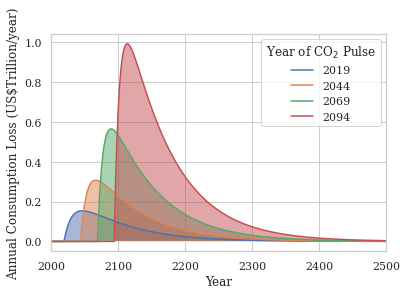

In [18]:
## years to calculate SCC
first_perturbed_year = last_historical_year
last_perturbed_year = 2500
year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

# consumption_discount = 0.035
# consumption_discount = consumption_growth + 0.015

SCC_list = []

discounted_consumption_loss_list = []
perturbed_year_dcl_list = []

for j in range(len(year_of_perturbation)):  # len(year_of_perturbation)
    ## define perturbed temperature profile for a given year
    T_TCRE = 0.00054  # need to check this for FAIR!
    k_s = 0.12
    
#     num_of_GtCO2 = 500

    T_p = np.zeros(T_forecast_length)
    for i in range(len(T_forecast_years)):
        if year_of_perturbation[j] <= T_forecast_years[i]:
            T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))*num_of_GtCO2  # # perturbed by 1GtCO2
    T_forecast_perturbed = T_forecast+T_p
    T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])
    
    ## define discount function
    num_of_years = len(years)
    discount_function = np.zeros(num_of_years)

    for i in range(num_of_years):
        if years[i] >= year_of_perturbation[j]:
            discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
    
    ## calculate SCC
#     cost = cost_of_perturbation(T=T, T_perturb=T_perturbed, W=W, discount_function=discount_function)
    gamma=2
    D0=0.00267

    S_Wt = D0*T**gamma
    S_Wt_perturb = D0*T_perturbed**gamma
    consumption_loss_fraction = S_Wt_perturb-S_Wt
    absolute_consumption_loss = consumption_loss_fraction*W
    discounted_consumption_loss = absolute_consumption_loss*discount_function
    area = simps(discounted_consumption_loss, dx=1)
    cost = area*10**12  # convert to dollar amount
    
    SCC = cost/(10**9*num_of_GtCO2)
    
    if j % 25 == 0:
#         plt.plot(years, absolute_consumption_loss, color="k")
        plt.plot(years, discounted_consumption_loss, label=j+last_historical_year)  # /(10**9*num_of_GtCO2)
        d = np.zeros(len(discounted_consumption_loss))
        plt.fill_between(years,discounted_consumption_loss,where=discounted_consumption_loss>=d, alpha=0.5)
        discounted_consumption_loss_list.append(discounted_consumption_loss)
        perturbed_year_dcl_list.append(j+last_historical_year+shift)

    
    
    if SCC < P_100:
        SCC_list.append(SCC)
    else:
        SCC_list.append(P_100)
        break

plt.legend(title="Year of CO$_2$ Pulse")
# plt.plot(T_forecast_years, T_forecast, label="unperturbed")
# plt.ylim(0, 2)
plt.xlim(2000, 2500)
plt.xlabel("Year")
plt.ylabel("Annual Consumption Loss (US$Trillion/year)")
# plt.yscale("log")
# plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)

# fig.savefig('figures/discounted_consumption.png', bbox_inches='tight', dpi = 300)

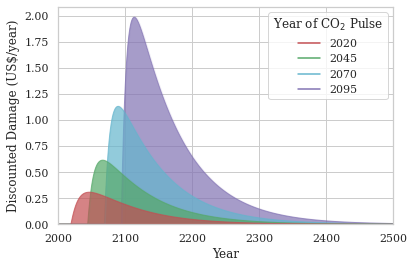

In [19]:
fig = plt.figure()

num = len(discounted_consumption_loss_list)

discounted_consumption_loss_list = np.asarray(discounted_consumption_loss_list)*(10**12)/(num_of_GtCO2*10**9)

for i in range(num):
    plt.plot(years+shift, discounted_consumption_loss_list[num-i-1], label=perturbed_year_dcl_list[num-i-1], alpha=0.1, color=color_list[num-i-1])  # /(10**9*num_of_GtCO2)   k
    d = np.zeros(len(discounted_consumption_loss_list[num-i-1]))
    plt.fill_between(years,discounted_consumption_loss_list[num-i-1],where=discounted_consumption_loss[num-i-1]>=d, alpha=0.7, color=color_list[num-i-1])


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

# plt.plot(T_forecast_years, T_forecast, label="unperturbed")
# plt.ylim(0, 2)
plt.xlim(2000, 2500)
plt.ylim(0)

plt.xlabel("Year")
plt.ylabel("Discounted Damage (US$/year)")
# plt.yscale("log")
# plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)

plt.legend(reversed(plt.legend().legendHandles), reversed(labels), title="Year of CO$_2$ Pulse")
leg = ax.get_legend()

leg.legendHandles[0].set_alpha(1)
leg.legendHandles[1].set_alpha(1)
leg.legendHandles[2].set_alpha(1)
leg.legendHandles[3].set_alpha(1)
# leg.legendHandles[4].set_alpha(1)

<Figure size 432x288 with 0 Axes>

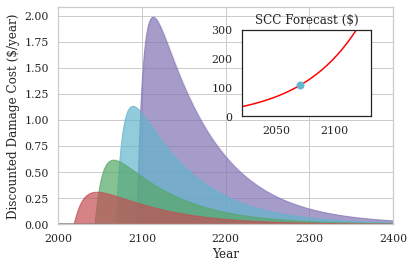

In [20]:
fig = plt.figure()

# fig, ax = plt.subplots()  

sns.set_style("whitegrid")
plt.rc('font', family='serif')
fig, ax1 = plt.subplots()

num = len(discounted_consumption_loss_list)

for i in range(num):
    plt.plot(years+shift, discounted_consumption_loss_list[num-i-1], label=perturbed_year_dcl_list[num-i-1], alpha=0.1, color=color_list[num-i-1])  # /(10**9*num_of_GtCO2)   k
    d = np.zeros(len(discounted_consumption_loss_list[num-i-1]))
    plt.fill_between(years,discounted_consumption_loss_list[num-i-1],where=discounted_consumption_loss[num-i-1]>=d, alpha=0.7, color=color_list[num-i-1])


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

# plt.plot(T_forecast_years, T_forecast, label="unperturbed")
# plt.ylim(0, 2)
plt.xlim(2000, 2400)
plt.ylim(0)

plt.xlabel("Year")
plt.ylabel("Discounted Damage Cost ($/year)")
# plt.yscale("log")
# plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)

# plt.legend(reversed(plt.legend().legendHandles), reversed(labels), title="Year of CO$_2$ Pulse")
# leg = ax.get_legend()

# leg.legendHandles[0].set_alpha(1)
# leg.legendHandles[1].set_alpha(1)
# leg.legendHandles[2].set_alpha(1)
# leg.legendHandles[3].set_alpha(1)
# leg.legendHandles[4].set_alpha(1)
sns.set_style("white")
plt.rc('font', family='serif')
left, bottom, width, height = [0.55, 0.5, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_ylim(0, 300)
ax2.set_xlim(2020, 2132)
ax2.title.set_text("SCC Forecast ($)")

value_2070 = SCC_list[2070+shift-2020]

ax2.plot(year_of_perturbation[:len(SCC_list)]+shift, SCC_list, color="red")
ax2.plot([2070], [value_2070], color="c", ms=7, marker='o')
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

fig.savefig('figures/discounted_consumption.png', bbox_inches='tight', dpi = 300)

In [21]:
sns.set_style("whitegrid")
plt.rc('font', family='serif')

In [22]:
len(year_of_perturbation)

482

In [23]:
SCC_array = np.asarray(SCC_list)  # convert to numpy array

In [24]:
# SCC_array

Text(0, 0.5, 'SCC ($)')

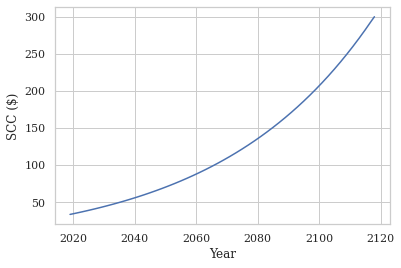

In [25]:
plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

### Check 100% abatement has been achieved!

In [26]:
if SCC_array[-1] < P_100:
    print("P_100 not achieved by achieved by final perturbed year")

In [27]:
SCC_forecasted = []

for i in range(T_forecast_length):
    if i < len(SCC_array):
        SCC_forecasted.append(SCC_array[i])
    else:
#         SCC_forecasted.append(SCC_array[-1])
        SCC_forecasted.append(P_100)

SCC_forecasted = np.array(SCC_forecasted)

In [28]:
# SCC_forecasted

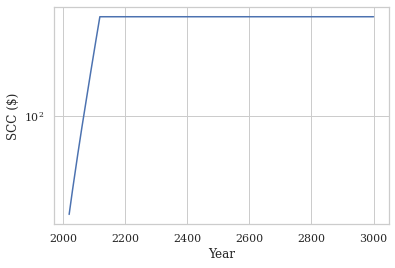

In [29]:
plt.plot(T_forecast_years, SCC_forecasted)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

## 3. Abatement as a function of time

In [30]:
P0 = SCC_forecasted[0]

In [31]:
forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)  # , r=consumption_discount

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_5354/3349198834.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


problems with certain values due to constraints of the model

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_5354/3349198834.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_5354/3349198834.py:21: RuntimeWarning: divide by zero encountered in reciprocal
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_5354/3349198834.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_5354/3349198834.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_5354/3349198834.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


2


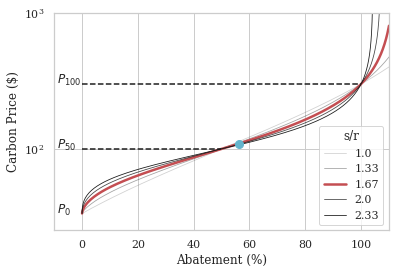

In [32]:
fig = plt.figure()

MACC_SCC = np.arange(P0, 10000)
MACC_abatement = abatement(P=MACC_SCC, P0=P0)

MACC_SCC_50 = np.arange(P0, P_50)
MACC_P_50 = np.ones(len(MACC_SCC_50))*P_50
MACC_abatement_50 = abatement(P=MACC_SCC_50, P0=P0)*100 

MACC_SCC_100 = np.arange(P0, P_100)
MACC_P_100 = np.ones(len(MACC_SCC_100))*P_100
MACC_abatement_100 = abatement(P=MACC_SCC_100, P0=P0)*100 

r = 0.03
s_r_array = np.linspace(1, 7/3, 5)
# s_r_array = np.linspace(0.52, 1, 5)
s_array = r*s_r_array
alpha_array = np.linspace(0.2, 1, len(s_array))
for i in range(len(s_array)):
    if i == 2:
        plt.plot(MACC_abatement*100, MACC_SCC, color="r", linewidth=2.5, label="1.67")
        print(i)
    else:
        plt.plot(abatement(P=MACC_SCC, P0=P0, s=s_array[i])*100, MACC_SCC, color="k", linewidth=0.8, alpha=alpha_array[i], label=np.round(s_array[i]/0.03, 2))

# plt.plot(MACC_abatement*100, MACC_SCC, color="r", linewidth=1, label="1.67")

plt.plot(MACC_abatement_50, MACC_P_50, color="k", linestyle="dashed")
plt.plot(MACC_abatement_100, MACC_P_100, color="k", linestyle="dashed")

plt.xlabel("Abatement (%)")
plt.ylabel("Carbon Price ($)")
plt.yscale("log")
# plt.ylim(10, 1000)
plt.gca().set_ylim(top=1000)
plt.xlim(-10, 110)
# plt.xlim(40, 60)
# plt.ylim(50, 150)

abatement_2070 = abatement(P=value_2070, P0=P0)*100

plt.plot([abatement_2070], [value_2070], color="c", ms=8, marker='o')

# plt.text(-0.09, P0, r'$P_{0}$')
# plt.text(-0.09, P_50, r'$P_{50}$')
# plt.text(-0.09, P_100, r'$P_{100}$')
plt.text(-9, P0, r'$P_{0}$')
plt.text(-9, P_50, r'$P_{50}$')
plt.text(-9, P_100, r'$P_{100}$')
plt.legend(title="s/r")
fig.savefig('figures/MACC.png', bbox_inches='tight', dpi = 300)

In [33]:
value_2070

109.36380583965985

In [34]:
abatement(P=value_2070, P0=P0)*100

56.14507246057451

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_5354/3349198834.py:21: RuntimeWarning: invalid value encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


Text(0, 0.5, 'dP/dA at P$_{50}$')

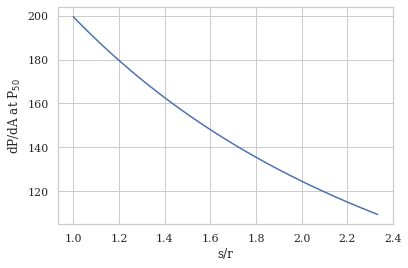

In [35]:
MACC_SCC_short = np.arange(33, 200)
r = 0.03
s_r_array = np.linspace(1, 7/3, 100)
s_array = r*s_r_array

grad = []
for i in range(len(s_array)):
#     print(np.gradient(abatement(P=MACC_SCC_short, P0=P0, s=s_array[i]), MACC_SCC_short)[17])
    grad.append(np.gradient(abatement(P=MACC_SCC_short, P0=P0, s=s_array[i]))[67])
#     print(np.gradient(abatement(P=MACC_SCC_short, P0=P0, s=s_array[i]), MACC_SCC_short)[0])

plt.plot(s_r_array, 1/np.asarray(grad))
plt.xlabel("s/r")
plt.ylabel("dP/dA at P$_{50}$")

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_5354/3349198834.py:21: RuntimeWarning: invalid value encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


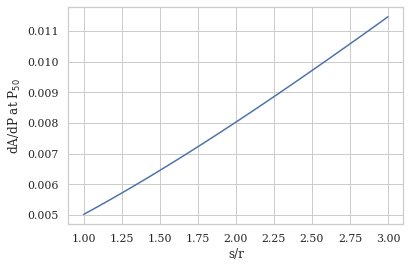

In [37]:
fig = plt.figure()

MACC_SCC_short = np.arange(33, 200)
r = 0.03
s_r_array = np.linspace(1, 3, 100)  #7/3
s_array = r*s_r_array

grad = []
for i in range(len(s_array)):
#     print(np.gradient(abatement(P=MACC_SCC_short, P0=P0, s=s_array[i]), MACC_SCC_short)[17])
    grad.append(np.gradient(abatement(P=MACC_SCC_short, P0=P0, s=s_array[i]))[67])
#     print(np.gradient(abatement(P=MACC_SCC_short, P0=P0, s=s_array[i]), MACC_SCC_short)[0])

plt.plot(s_r_array, np.asarray(grad))
plt.xlabel("s/r")
plt.ylabel("dA/dP at P$_{50}$")
fig.savefig('figures/abatement_elasticity.png', bbox_inches='tight', dpi = 300)

In [38]:
MACC_SCC_short[17]

50

Text(0, 0.5, 'Abatement')

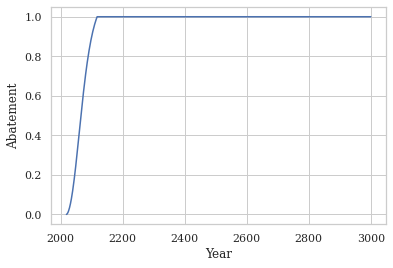

In [39]:
plt.plot(T_forecast_years, forecasted_abatement)
plt.xlabel("Year")
plt.ylabel("Abatement")

## 4. Abatement to emissions

In [40]:
ssp_df = pd.read_csv("ssp245.csv", index_col=0)

In [41]:
ssp245_CO2_past = ssp_df["carbon_dioxide"]*(44/12)  

In [42]:
# CO2_baseline = ssp245_CO2_past[2019] # set baseline to current emissions
CO2_baseline = 40

In [43]:
forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

In [44]:
CO2_baseline_emissions = CO2_baseline * np.ones(len(T_forecast_years))

In [45]:
# fig = plt.figure()
# plt.plot(ssp245_CO2_past, label="Historical")
# plt.plot(T_forecast_years, forecasted_emissions, label="Forecasted")
# plt.plot(T_forecast_years, CO2_baseline_emissions, label="Baseline")
# plt.xlabel("Year")
# plt.ylabel("CO2 Emissions (GtCO2)")
# plt.legend(title="Emissions")
# fig.savefig('figures/emissions.png', bbox_inches='tight', dpi = 300)

## 5. Cumulative Emissions to Temperature Change

In [46]:
cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

In [47]:
temperature_change = T_TCRE*cumulative_emissions_array

In [48]:
max(temperature_change)

1.0549609581470119

In [49]:
T_forecast_iteration0 = T_2019 + temperature_change
# T_forecast_iteration0_plateau = T_2019 + temperature_change_plateau

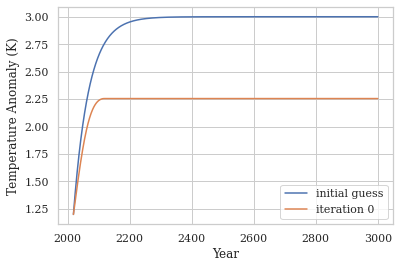

In [50]:
plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_iteration0, label="iteration 0")
# plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (K)")
plt.legend()

# Without Plateau

In [51]:
## years to calculate SCC
first_perturbed_year = last_historical_year
last_perturbed_year = 2500
year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

# consumption_discount = 0.035
# consumption_discount = consumption_growth + 0.015

SCC_list = []

discounted_consumption_loss_list = []
perturbed_year_dcl_list = []

for j in range(len(year_of_perturbation)):  # len(year_of_perturbation)
    ## define perturbed temperature profile for a given year
    T_TCRE = 0.00054  # need to check this for FAIR!
    k_s = 0.12
    
#     num_of_GtCO2 = 500

    T_p = np.zeros(T_forecast_length)
    for i in range(len(T_forecast_years)):
        if year_of_perturbation[j] <= T_forecast_years[i]:
            T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))*num_of_GtCO2  # # perturbed by 1GtCO2
    T_forecast_perturbed = T_forecast+T_p
    T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])
    
    ## define discount function
    num_of_years = len(years)
    discount_function = np.zeros(num_of_years)

    for i in range(num_of_years):
        if years[i] >= year_of_perturbation[j]:
            discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
    
    ## calculate SCC
#     cost = cost_of_perturbation(T=T, T_perturb=T_perturbed, W=W, discount_function=discount_function)
    gamma=2
    D0=0.00267

    S_Wt = D0*T**gamma
    S_Wt_perturb = D0*T_perturbed**gamma
    consumption_loss_fraction = S_Wt_perturb-S_Wt
    absolute_consumption_loss = consumption_loss_fraction*W
    discounted_consumption_loss = absolute_consumption_loss*discount_function
    area = simps(discounted_consumption_loss, dx=1)
    cost = area*10**12  # convert to dollar amount
    
    SCC = cost/(10**9*num_of_GtCO2)
    
    SCC_list.append(SCC)

SCC_array = np.asarray(SCC_list) 
# plt.legend(title="Year of CO$_2$ Pulse")
# plt.plot(T_forecast_years, T_forecast, label="unperturbed")
# plt.ylim(0, 2)
# plt.xlim(2000, 2500)
# plt.xlabel("Year")
# plt.ylabel("Annual Consumption Loss (US$Trillion/year)")
# plt.yscale("log")
# plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)

# fig.savefig('figures/discounted_consumption.png', bbox_inches='tight', dpi = 300)

In [52]:
SCC_forecasted = []

for i in range(T_forecast_length):
    if i < len(SCC_array):
        SCC_forecasted.append(SCC_array[i])
    else:
#         SCC_forecasted.append(SCC_array[-1])
        SCC_forecasted.append(SCC_array[-1])

SCC_forecasted = np.array(SCC_forecasted)

In [53]:
P0 = SCC_forecasted[0]

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_5354/3349198834.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


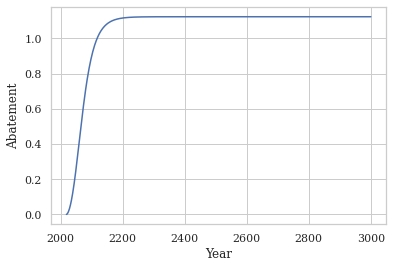

In [54]:

## 3. Abatement as a function of time

P0 = SCC_forecasted[0]

forecasted_abatement_plateau = abatement(P=SCC_forecasted, P0=P0)  # , r=consumption_discount

plt.plot(T_forecast_years, forecasted_abatement_plateau)
plt.xlabel("Year")
plt.ylabel("Abatement")

## 4. Abatement to emissions

# ssp_df = pd.read_csv("ssp245.csv", index_col=0)

# ssp245_CO2_past = ssp_df["carbon_dioxide"]*(44/12)  

# CO2_baseline = ssp245_CO2_past[2019] # set baseline to current emissions

CO2_baseline = 40

forecasted_emissions_plateau = abatement_to_emissions(forecasted_abatement_plateau, CO2_baseline)

CO2_baseline_emissions = CO2_baseline * np.ones(len(T_forecast_years))

forecasted_emission_2070 = abatement_to_emissions(abatement_2070/100, CO2_baseline)

In [55]:
abatement_2070

56.14507246057451

In [56]:
forecasted_emission_2070

17.541971015770198

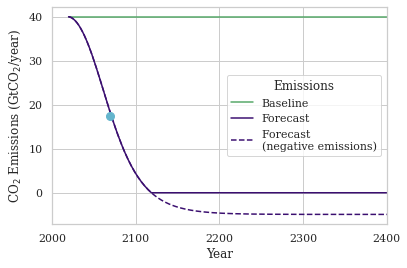

In [57]:
# fig = plt.figure()
fig, ax = plt.subplots()  
# plt.plot(ssp245_CO2_past, label="Historical", color="m")
plt.plot(T_forecast_years+shift, CO2_baseline_emissions, label="Baseline", color="g")
plt.plot(T_forecast_years+shift, forecasted_emissions, label="Forecast", color=cm.magma(0.2))
plt.plot(T_forecast_years+shift, forecasted_emissions_plateau, label="Forecast \n(negative emissions)", color=cm.magma(0.2), linestyle="dashed") #i/len(Y_array)
plt.plot([2070], [forecasted_emission_2070], color="c", ms=8, marker='o')
plt.xlabel("Year")
plt.ylabel("CO$_{2}$ Emissions (GtCO$_{2}$/year)")
plt.xlim(2000, 2400)
plt.legend(title="Emissions")
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
fig.savefig('figures/emissions.png', bbox_inches='tight', dpi = 300)

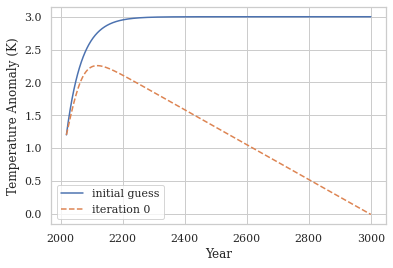

In [58]:
cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions_plateau)[:-1])

temperature_change = T_TCRE*cumulative_emissions_array

max(temperature_change)

# T_forecast_iteration0 = T_2019 + temperature_change
T_forecast_iteration0_plateau = T_2019 + temperature_change

plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0", linestyle="dashed")
# plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (K)")
plt.legend()

# Iterating Further

In [59]:
# T_forecast_first_loop = T_forecast_iteration0_plateau
# T_forecast_iteration = T_forecast_iteration0_plateau

In [60]:
T_forecast_first_loop = T_forecast_iteration0
T_forecast_iteration = T_forecast_iteration0

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_5354/3349198834.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_5354/3349198834.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_5354/3349198834.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_5354/3349198834.py:21: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


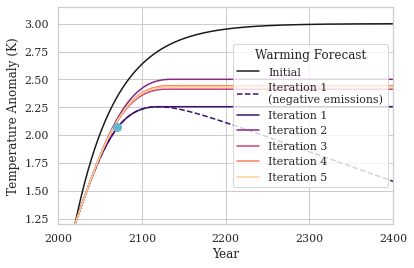

In [61]:
fig = plt.figure()

num_of_iterations = 99

first_perturbed_year = last_historical_year

year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

plt.plot(T_forecast_years+shift, T_forecast, label="Initial", color="k")
plt.plot(T_forecast_years+shift, T_forecast_iteration0_plateau, label="Iteration 1 \n(negative emissions)", color=cm.magma(0.2), linestyle="dashed")
plt.plot(T_forecast_years+shift, T_forecast_first_loop, label="Iteration 1", color=cm.magma(0.2))


for k in range(4): #num_of_iterations
    T_iteration = np.concatenate([T_gas_df['CO2_best'],T_forecast_iteration[1:]])

    SCC_list = []

    for j in range(len(year_of_perturbation)):
        ## define perturbation
        T_TCRE = 0.00054  # need to check this! *100 for 100GtCO2 added
        k_s = 0.12

        T_p = np.zeros(T_forecast_length)

        for i in range(len(T_forecast_years)):
            if year_of_perturbation[j] <= T_forecast_years[i]:
                T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))

        T_forecast_perturbed = T_forecast_iteration+T_p

        T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])

        ## define discount function
        num_of_years = len(years)

        discount_function = np.zeros(num_of_years)

        for i in range(num_of_years):
            if years[i] >= year_of_perturbation[j]:
                discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
        cost = cost_of_perturbation(T=T_iteration, T_perturb=T_perturbed, W=W, discount_function=discount_function)
        SCC = cost/(10**9)
        if SCC < P_100:
            SCC_list.append(SCC)
        else:
            SCC_list.append(P_100)
            break

    SCC_array = np.asarray(SCC_list)

    SCC_forecasted = []

    for i in range(T_forecast_length):
        if i < len(SCC_array):
            SCC_forecasted.append(SCC_array[i])
        else:
            SCC_forecasted.append(P_100)

    SCC_forecasted = np.array(SCC_forecasted)

    P0 = SCC_forecasted[0]

    forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)  # , r=consumption_discount
    forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

    cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

    temperature_change = T_TCRE*cumulative_emissions_array
    
    T_forecast_iteration = T_2019 + temperature_change
    
    plt.plot(T_forecast_years+shift, T_forecast_iteration, label="Iteration "+str(k+2), color=cm.magma(0.2+0.7*(k+1)/4))
#     if k == 4:
#         plt.plot(T_forecast_years+shift, T_forecast_iteration, label="Iteration "+str(k+2), color="y")
#     else:
#         plt.plot(T_forecast_years+shift, T_forecast_iteration, label="Iteration "+str(k+2))
    
    if k == 0:
        peak_T = max(T_forecast_iteration)
    else:
        previous_peak_T = peak_T
        peak_T = max(T_forecast_iteration)
        if abs(peak_T - previous_peak_T) < 0.005:
            print(k)
            break
    
    if k == num_of_iterations - 1:
        print("convergence condition not achieved")
        print(f"{consumption_discount=}")
        print(f"{consumption_growth=}")
        print(f"{P_50=}")
        print(f"{s=}")
        print(f"{r=}")
        print(f"{P_100=}")


plt.plot([2070], [T_forecast_iteration0_plateau[2070-2019]], color="c", ms=8, marker='o')        
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (K)")
plt.xlim(2000, 2400)
plt.ylim(1.2)
plt.legend(title="Warming Forecast", loc=7)
fig.savefig('figures/temperature_iteration.png', bbox_inches='tight', dpi = 300)

***this is fairly analogous to the Newton-Raphson Method***
- the initial temperature profile is essentially just a starting guess; getting pushed toward temperature profile solution
- could stop the iterations when the difference between two consecutive lines is small

In [62]:
## peak Temperature
max(T_forecast_iteration)

2.4315959326010548

under default settings: 2.0439370757585076

In [63]:
SCC_forecasted[0]

28.224933215165606